In [1]:
import dsautils.calstatus as cs
from dsautils.dsa_store import DsaStore
from astropy.time import Time
import time
import datetime
import yaml
from dsacalib.ms_io import average_beamformer_solutions
import glob
import os
import numpy as np
from pkg_resources import resource_filename
import astropy.units as u
from dsautils import cnf
from dsacalib.plotting import summary_plot, plot_current_beamformer_solutions
from dsacalib.plotting import plot_beamformer_weights
from dsacalib.routines import get_files_for_cal, calibrate_measurement_set
from dsacalib.ms_io import convert_calibrator_pass_to_ms, uvh5_to_ms
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
CONF = cnf.Conf()
ETCD = DsaStore()

## Averaging beamformer solutions

To plot the beamformer solutions and choose ones to average:

In [2]:
CORR_PARAMS = CONF.get('corr')
CAL_PARAMS = CONF.get('cal')
MFS_PARAMS = CONF.get('fringe')

REFANTS = CAL_PARAMS['refant']
if isinstance(REFANTS, (str, int)):
    REFANTS = [REFANTS]
MSDIR = CAL_PARAMS['msdir']

BEAMFORMER_DIR = CAL_PARAMS['beamformer_dir']

ANTENNAS = np.array(list(CORR_PARAMS['antenna_order'].values()))
POLS = CORR_PARAMS['pols_voltage']
ANTENNAS_NOT_IN_BF = CAL_PARAMS['antennas_not_in_bf']
print(ANTENNAS_NOT_IN_BF)
CORR_LIST = list(CORR_PARAMS['ch0'].keys())
CORR_LIST = [int(cl.strip('corr')) for cl in CORR_LIST]

['100 A', '100 B', '101 A', '101 B', '102 A', '102 B', '116 A', '116 B', '103 A', '103 B', '104 A', '104 B', '105 A', '105 B', '106 A', '106 B', '107 A', '107 B', '108 A', '108 B', '109 A', '109 B', '110 A', '110 B', '111 A', '111 B', '112 A', '112 B', '113 A', '113 B', '114 A', '114 B', '115 A', '115 B', '117 A', '117 B', '43 A', '43 B', '44 A', '44 B', '45 A', '45 B', '46 A', '46 B', '47 A', '47 B', '48 A', '48 B', '49 A', '49 B']


In [3]:
fn_dat = glob.glob('/home/user/beamformer_weights/beamformer_weights*corr07*.dat')

bfnames = []
for fn in fn_dat:
    sp = fn.split('_corr07_')
    if len(sp) > 1:
        if '_' in sp[1]:
            bfnames.append(sp[1].rstrip('.dat'))
bfnames = sorted(bfnames)

In [4]:
bfnames

['3C273_2021-01-26T11:58:16',
 '3C273_2021-01-27T11:54:20',
 '3C409_2020-10-25T01:51:43',
 'J000020+553908_2021-06-10T14:37:52',
 'J000020+553908_2021-08-11T10:34:08',
 'J000020+553908_2021-08-12T10:30:12',
 'J000020+553908_2021-08-16T10:14:29',
 'J000020+553908_2021-08-17T10:10:33',
 'J000020+553908_2021-08-18T10:06:37',
 'J000020+553908_2021-08-20T09:58:45',
 'J000020+553908_2021-08-21T09:54:49',
 'J000020+553908_2021-08-24T09:43:02',
 'J000020+553908_2021-08-27T09:31:14',
 'J000020+553908_2021-08-28T09:27:18',
 'J000020+553908_2021-08-30T09:19:27',
 'J000020+553908_2021-08-31T09:15:31',
 'J000020+553908_2021-09-01T09:11:35',
 'J000020+553908_2021-09-02T09:07:39',
 'J000020+553908_2021-09-04T08:59:47',
 'J000020+553908_2021-09-06T08:51:55',
 'J000020+553908_2021-09-07T08:47:59',
 'J000020+553908_2021-09-08T08:44:03',
 'J000020+553908_2021-09-09T08:40:08',
 'J000020+553908_2021-09-11T08:32:16',
 'J000020+553908_2021-09-16T08:12:36',
 'J000020+553908_2021-09-17T08:08:40',
 'J000020+553

In [5]:
corrlist = [3,4,5,6,7,8,10,11,12,14,15,16,18,19,21,22]  # latest set
antennas = np.array(list(CONF.get('corr')['antenna_order'].values()))
gaindir = '/home/user/beamformer_weights'

In [25]:
#bfnames2 = [bfn for bfn in bfnames if 'J000020+553908' in bfn and '2021-10' in bfn]
bfnames2 = [bfn for bfn in bfnames if '2021-10-20' in bfn or '2021-10-19' in bfn]
#calnames = list(set([bfn.split('_')[0] for bfn in bfnames2]))

In [26]:
print(bfnames2)

['J000020+553908_2021-10-19T06:02:51', 'J000020+553908_2021-10-20T05:58:55', 'J014829+533243_2021-10-19T07:51:01', 'J014829+533243_2021-10-20T07:47:05', 'J022303+544849_2021-10-19T08:25:35', 'J022303+544849_2021-10-20T08:21:39', 'J032719+552029_2021-10-19T09:29:49', 'J065514+540900_2021-10-19T12:57:15', 'J083454+553421_2021-10-19T14:36:32', 'J083454+553421_2021-10-20T14:32:36', 'J095738+552257_2021-10-19T15:58:50', 'J095738+552257_2021-10-20T15:54:54', 'J121529+533554_2021-10-19T18:15:54', 'J141120+521209_2021-10-19T20:11:09', 'J152405+542818_2021-10-19T21:23:31', 'J194431+544807_2021-10-20T01:43:10', 'J223119+540936_2021-10-19T04:33:49', 'J223119+540936_2021-10-20T04:29:53', 'J234348+534840_2021-10-19T05:46:19', 'J234348+534840_2021-10-20T05:42:23'] ['J223119+540936', 'J095738+552257', 'J000020+553908', 'J141120+521209', 'J121529+533554', 'J032719+552029', 'J022303+544849', 'J065514+540900', 'J152405+542818', 'J194431+544807', 'J234348+534840', 'J083454+553421', 'J014829+533243']


In [27]:
gains = np.zeros((len(bfnames2), len(antennas), len(corrlist), 48, 2),
            dtype=np.complex)

for i, beamformer_name in enumerate(bfnames2):
    for corridx, corr in enumerate(corrlist):
        with open('{0}/beamformer_weights_corr{1:02d}_{2}.dat'.format(gaindir,
                                                                      corr,
                                                                      beamformer_name),
                  'rb') as f:
            data = np.fromfile(f, '<f4')
        temp = data[64:].reshape(64, 48, 2, 2)
        gains[i, :, corridx, :, :] = temp[..., 0]+1.0j*temp[..., 1]
gains = gains.reshape((len(bfnames2), len(antennas), len(corrlist)*48, 2))

/home/user/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/user/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


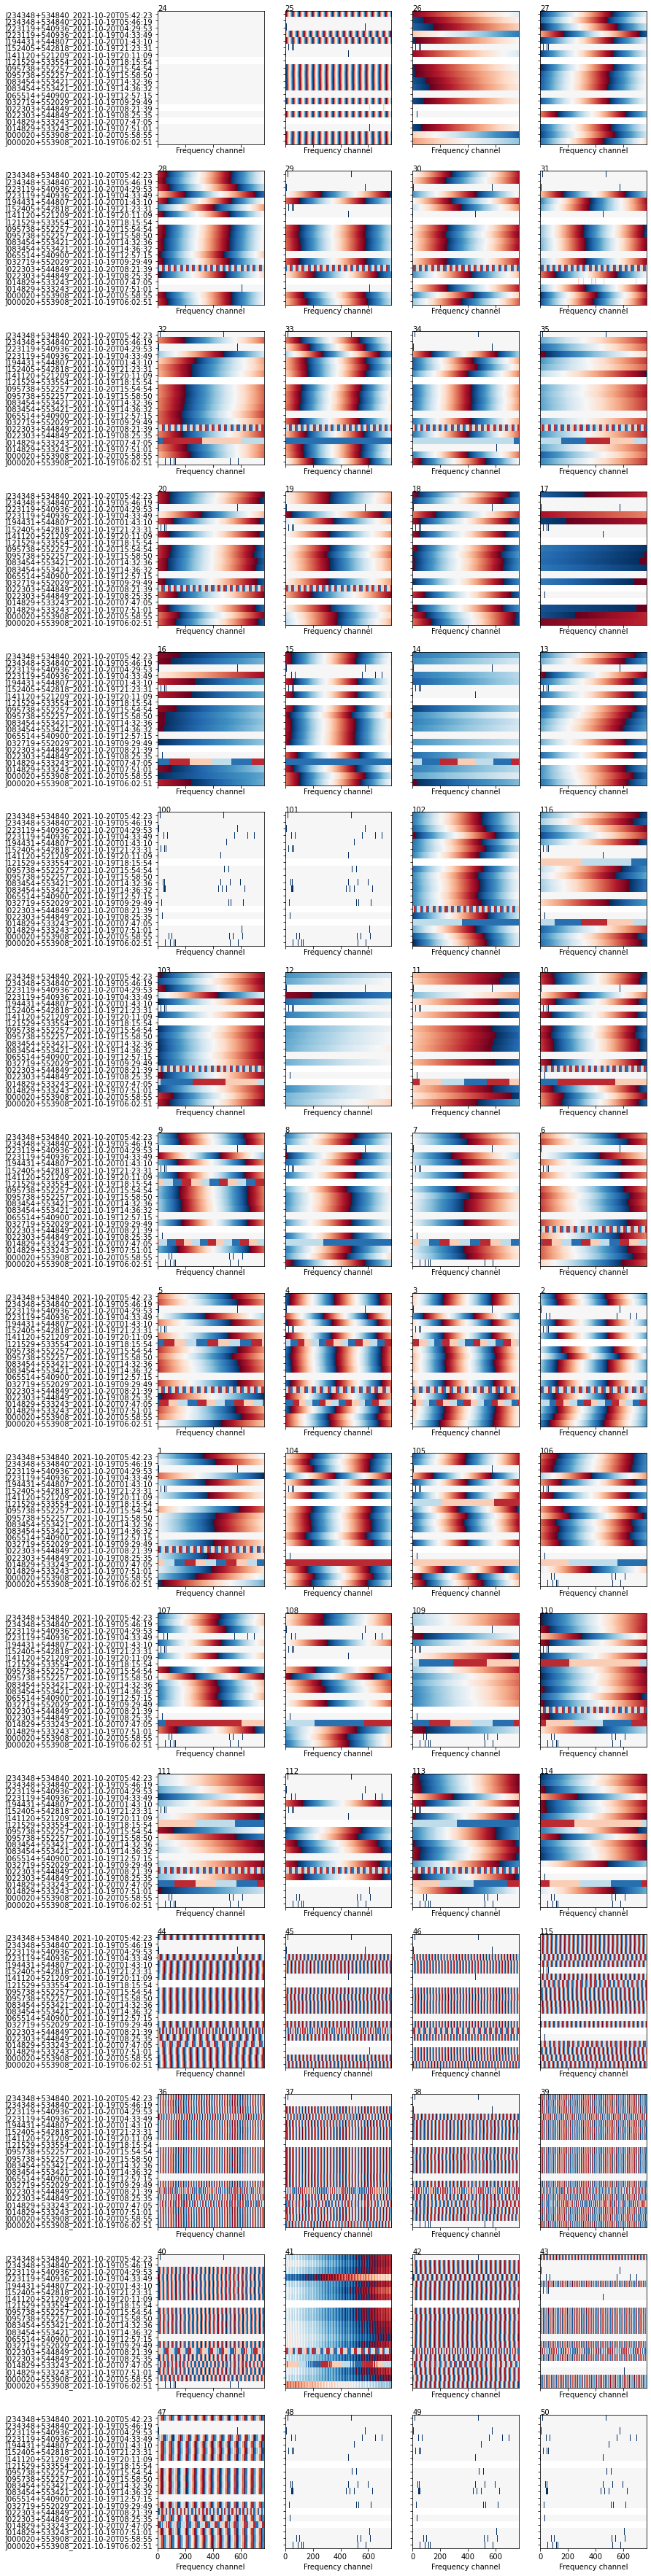

In [42]:
refant = 24
nx = 4
ny = len(antennas)//nx
if len(antennas)%nx > 0:
    ny += 1
_, ax = plt.subplots(ny, nx, figsize=(3*nx, 4*ny),
                     sharex=True, sharey=True)
ax[0, 0].set_yticks(np.arange(len(bfnames2)))

for axi in ax[0, :]:
    axi.set_yticklabels(bfnames2)
ax = ax.flatten()

for i in np.arange(len(antennas)):
    ax[i].imshow(np.angle(gains[:, i, :, 0]/gains[:, 0, :, 0]),
                 vmin=-np.pi, vmax=np.pi, aspect='auto', origin='lower', interpolation='None',
                 cmap=plt.get_cmap('RdBu'))
    ax[i].annotate('{0}'.format(antennas[i]), (0, 1), xycoords='axes fraction')
    ax[i].set_xlabel('Frequency channel')

In [84]:
# current
# this will be a single, trusted solution after every restart
# after service is up, this will be updated
!ls /mnt/data/dsa110/T3/calibs/beamformer_weights_corr22_2021-10-18T23:20:14.dat

/mnt/data/dsa110/T3/calibs/beamformer_weights_corr22_2021-10-18T23:20:14.dat


In [55]:
gaindir = '/mnt/data/dsa110/T3/calibs/'
fn_dat = glob.glob(gaindir + 'beamformer_weights*2021-10-18T23:20:14.dat')

bfnames = []
for fn in fn_dat:
    bfnames.append(os.path.basename(fn))
bfnames = sorted(bfnames)

In [56]:
bfnames


['beamformer_weights_corr03_2021-10-18T23:20:14.dat',
 'beamformer_weights_corr04_2021-10-18T23:20:14.dat',
 'beamformer_weights_corr05_2021-10-18T23:20:14.dat',
 'beamformer_weights_corr06_2021-10-18T23:20:14.dat',
 'beamformer_weights_corr07_2021-10-18T23:20:14.dat',
 'beamformer_weights_corr08_2021-10-18T23:20:14.dat',
 'beamformer_weights_corr10_2021-10-18T23:20:14.dat',
 'beamformer_weights_corr11_2021-10-18T23:20:14.dat',
 'beamformer_weights_corr12_2021-10-18T23:20:14.dat',
 'beamformer_weights_corr14_2021-10-18T23:20:14.dat',
 'beamformer_weights_corr15_2021-10-18T23:20:14.dat',
 'beamformer_weights_corr16_2021-10-18T23:20:14.dat',
 'beamformer_weights_corr18_2021-10-18T23:20:14.dat',
 'beamformer_weights_corr19_2021-10-18T23:20:14.dat',
 'beamformer_weights_corr21_2021-10-18T23:20:14.dat',
 'beamformer_weights_corr22_2021-10-18T23:20:14.dat']

In [70]:
gains = np.zeros((1, len(antennas), len(corrlist), 48, 2), dtype=np.complex)

for corridx, corr in enumerate(corrlist):
    ff = [bfn for bfn in bfnames if f'corr{corr:02}' in bfn]
    with open('{0}/{1}'.format(gaindir, ff[0]), 'rb') as f:
        data = np.fromfile(f, '<f4')
    temp = data[64:].reshape(64, 48, 2, 2)
    gains[0, :, corridx, :, :] = temp[..., 0]+1.0j*temp[..., 1]
gains = gains.reshape((1, len(antennas), len(corrlist)*48, 2))

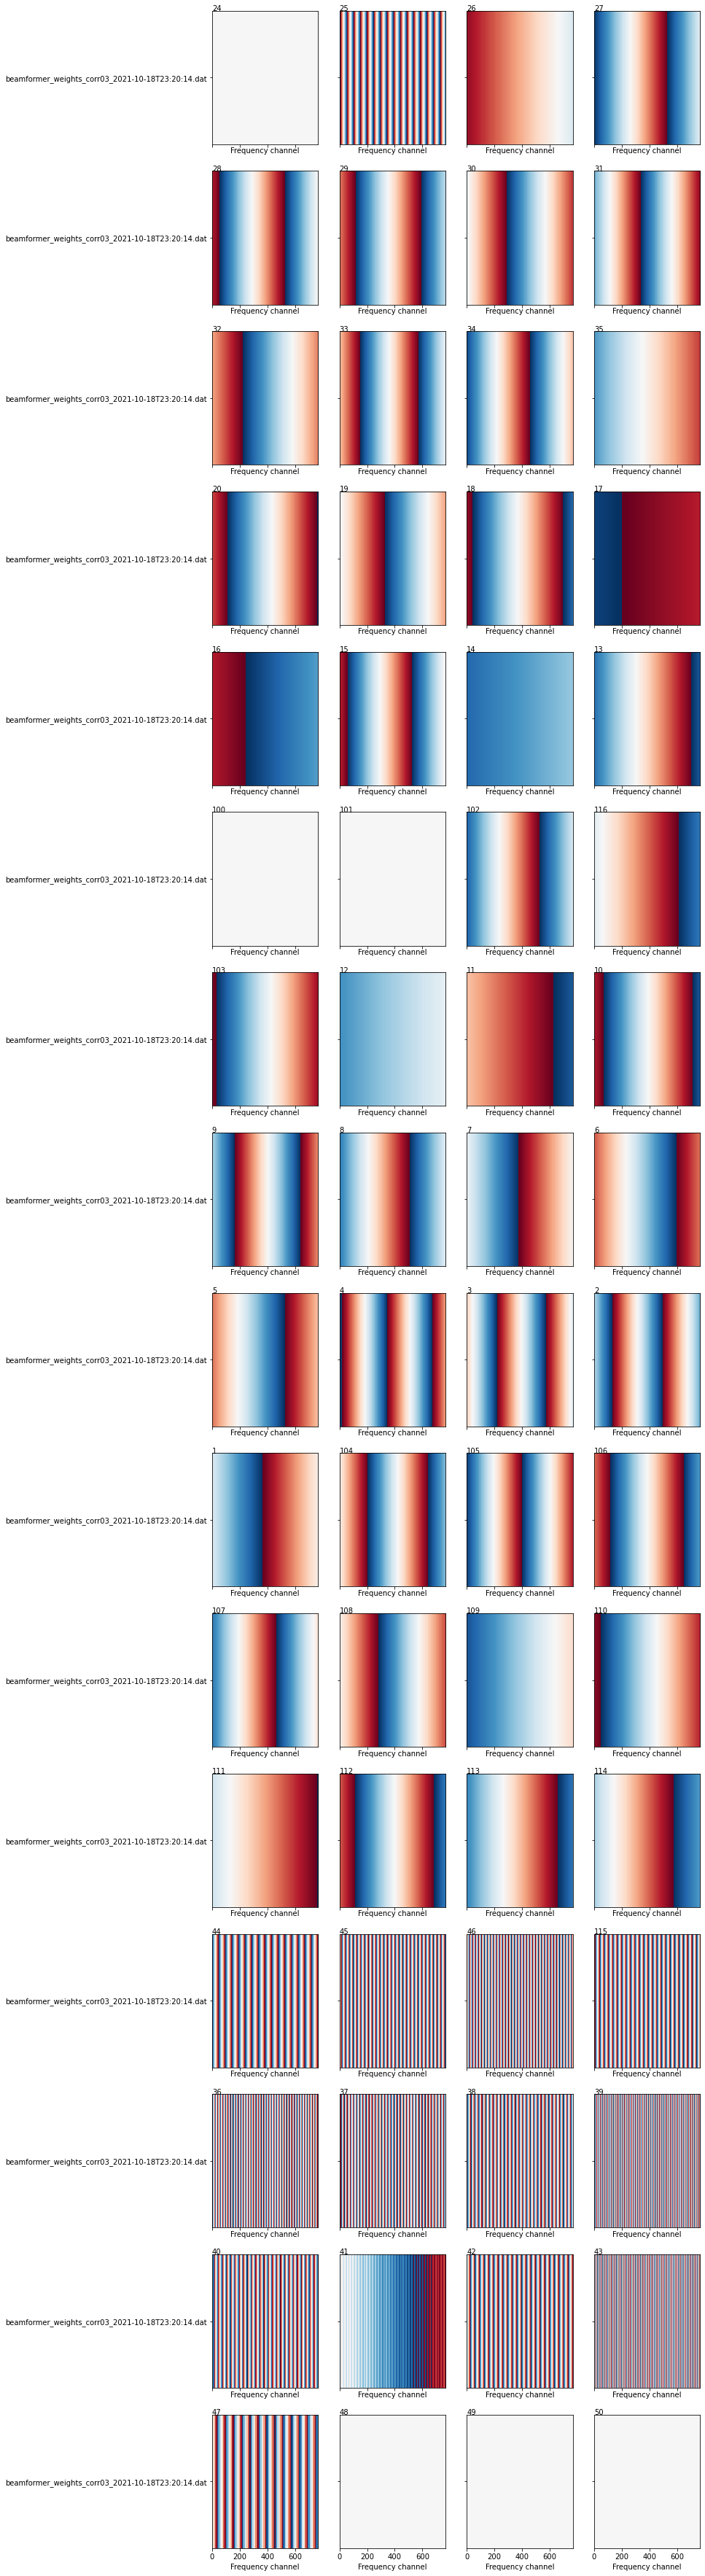

In [71]:
refant = 24
nx = 4
ny = len(antennas)//nx
if len(antennas)%nx > 0:
    ny += 1
_, ax = plt.subplots(ny, nx, figsize=(3*nx, 4*ny),
                     sharex=True, sharey=True)
ax[0, 0].set_yticks(np.arange(len(bfnames)))

for axi in ax[0, :]:
    axi.set_yticklabels(bfnames)
ax = ax.flatten()

for i in np.arange(len(antennas)):
    ax[i].imshow(np.angle(gains[:, i, :, 0]/gains[:, 0, :, 0]),
                 vmin=-np.pi, vmax=np.pi, aspect='auto', origin='lower', interpolation='None',
                 cmap=plt.get_cmap('RdBu'))
    ax[i].annotate('{0}'.format(antennas[i]), (0, 1), xycoords='axes fraction')
    ax[i].set_xlabel('Frequency channel')

Making the averaged solution:

In [5]:
with open(
    '{0}/beamformer_weights_{1}.yaml'.format(
        BEAMFORMER_DIR,
        bfnames[0]
    )
) as f:
    latest_solns = yaml.load(f, Loader=yaml.FullLoader)

In [6]:
now = Time(datetime.datetime.utcnow())
now.precision = 0
averaged_files, avg_flags = average_beamformer_solutions(
    bfnames,
    now,
    outdir=BEAMFORMER_DIR,
    corridxs=CORR_LIST,
    logger=None
)

(16, 64, 48, 2, 2)


/home/user/proj/dsa110-shell/dsa110-calib/dsacalib/ms_io.py:1600: RuntimeWarning: Mean of empty slice
  gains = np.nanmean(gains, axis=0) #np.nanmedian(gains, axis=0)


In [7]:
latest_solns['cal_solutions']['weight_files'] = averaged_files
latest_solns['cal_solutions']['source'] = [
    bfnames[0].split('_')[0]
]
latest_solns['cal_solutions']['caltime'] = [
    float(Time(bfnames[0].split('_')[1]).mjd)
]
for key, value in \
    latest_solns['cal_solutions']['flagged_antennas'].items():
    if 'casa solutions flagged' in value:
        value = value.remove('casa solutions flagged')
# Flag new bad solutions
idxant, idxpol = np.nonzero(avg_flags)
for i, ant in enumerate(idxant):
    key = '{0} {1}'.format(ANTENNAS[ant], POLS[idxpol[i]])
    if key not in \
        latest_solns['cal_solutions']['flagged_antennas'].keys():
        latest_solns['cal_solutions']['flagged_antennas'][key] = []
    latest_solns['cal_solutions']['flagged_antennas'][key] += \
        ['casa solutions flagged']
latest_solns['cal_solutions']['flagged_antennas'] = {
    key: value for key, value in
    latest_solns['cal_solutions']['flagged_antennas'].items()
    if len(value) > 0
}

In [8]:
with open(
    '{0}/beamformer_weights_{1}.yaml'.format(
        BEAMFORMER_DIR, now.isot
    ),
    'w'
) as file:
    print('writing bf weights')
    _ = yaml.dump(latest_solns, file)

writing bf weights


In [9]:
with open(
    '/home/user/beamformer_weights/beamformer_weights_{0}.yaml'.format(
        now.isot
    )
) as f:
    latest_solutions = yaml.load(f, Loader=yaml.FullLoader)
ETCD.put_dict(
    '/mon/cal/bfweights',
    {
        'cmd': 'update_weights',
        'val': latest_solns['cal_solutions']
    }
)

In [81]:
ETCD.get_dict('/mon/cal/bfweights')

{'cmd': 'update_weights',
 'val': {'caltime': [59508.88586805556,
   59508.83561342592,
   59508.755590277775,
   59508.66039351852,
   59508.60324074074,
   59508.53429398148,
   59508.39024305555,
   59508.34563657407,
   59508.32163194445,
   59508.24652777778,
   59508.235034722224,
   59508.06891203704],
  'delays': [[158, 158],
   [97, 150],
   [43, 43],
   [110, 110],
   [129, 129],
   [83, 82],
   [65, 64],
   [83, 82],
   [63, 63],
   [103, 103],
   [0, 0],
   [16, 15],
   [320, 320],
   [338, 337],
   [319, 318],
   [354, 354],
   [369, 368],
   [387, 386],
   [419, 418],
   [403, 404],
   [0, 0],
   [0, 0],
   [0, 0],
   [0, 0],
   [0, 0],
   [397, 397],
   [412, 412],
   [482, 481],
   [460, 459],
   [451, 451],
   [238, 237],
   [219, 218],
   [206, 206],
   [114, 115],
   [129, 129],
   [147, 147],
   [158, 158],
   [0, 0],
   [0, 0],
   [0, 0],
   [0, 0],
   [0, 0],
   [0, 0],
   [0, 0],
   [0, 0],
   [0, 0],
   [0, 0],
   [0, 0],
   [0, 0],
   [0, 0],
   [0, 0],
   [0, 